In [1]:
import argparse
import logging
import time

import torch
import torchtext
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.prototype.transforms import load_sp_model, PRETRAINED_SP_MODEL, SentencePieceTokenizer
from torchtext.utils import download_from_url
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchtext.vocab import GloVe, FastText
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np
import random
from sentence_transformers import SentenceTransformer

In [2]:
# EXPERIMENT SETTING

# embedding method
EMBD = 'sbert' # choose from 'GloVe' or 'sbert'
# number of classification class - according to different Data Set
NUM_CLASS = 4
# Corruption: if not then concatnate
INSERT = False 

## About Data Set

AG News (AG’s News Corpus) is a subdataset of AG's corpus of news articles constructed by assembling titles and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Sci/Tech”) of AG’s Corpus.

## Tokenizer
- Different models tolenize in different ways. 
    - Word2Vec / GloVe does words (WordLevel).
    - BERT does WordPiece.
    - The original transformer did BytePairEncoding.
    - FastText uses n-grams.


In [3]:
TOKENIZER = get_tokenizer("basic_english")

## Embedding: GloVE/sbert

In [4]:
# GloVe
GLOVE = GloVe(name='840B', dim=300)
#([6, 300])
GLOVE.get_vecs_by_tokens(TOKENIZER("Hello, How are you?"), lower_case_backup=True) 


# FASTTEXT = FastText()

# sbert
model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']
embeddings = model.encode(sentences) #([3, 384])

### Dataset & Preprocess(sbert)

In [5]:
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()

train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

model = SentenceTransformer('all-MiniLM-L6-v2')

train_mapping = {}
train_para = [_[1] for _ in train_dataset]
train_embedd = torch.from_numpy(model.encode(train_para))

train_mapping = dict(list(zip(train_para, train_embedd)))

test_mapping = {}
test_para = [_[1] for _ in test_dataset]
test_embedd = torch.from_numpy(model.encode(test_para))

test_mapping = dict(list(zip(test_para, test_embedd)))

In [7]:
sbert_mapping = dict(train_mapping, **test_mapping)

In [8]:
len(sbert_mapping)

127600

# Forward-Forward Algo

## Dataset - get Positive Samples & Negative Samples

In [70]:
# define collate_fn with embedding method
def vectorize_batch(batch, embed_method = 'GloVe'):
    Y, X = list(zip(*batch))
    
    if embed_method == 'GloVe':
      X = [TOKENIZER(x) for x in X]
      X_tensor = torch.zeros(len(batch), 300)
      for i, tokens in enumerate(X):
          X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens).mean(dim=0) ## Averaging Embedding accross all words of text document
    
    if embed_method == 'sbert': #slow
      X_tensor = torch.cat([sbert_mapping[x].unsqueeze(0) for x in X], dim=0)

    return X_tensor, torch.tensor(Y) - 1 

In [71]:
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

num_train = round(0.95*len(train_dataset))
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

# torch.Size([114000, embed]) torch.Size([114000])
train_loader = DataLoader(split_train_, batch_size=len(split_train_), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

# torch.Size([6000, embed]) torch.Size([6000])
valid_loader = DataLoader(split_valid_, batch_size=len(split_valid_), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

# torch.Size([7600, embed]) torch.Size([7600])
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

In [72]:
x_train, y = next(iter(train_loader))
x_train.shape, y.shape

(torch.Size([114000, 384]), torch.Size([114000]))

In [73]:
x_train[:5,:],y[:5]

(tensor([[-0.0738, -0.0039, -0.0488,  ...,  0.0543, -0.0637,  0.0372],
         [ 0.0397,  0.0829,  0.0245,  ..., -0.0810, -0.1030,  0.0403],
         [-0.0524, -0.0891,  0.0136,  ..., -0.0383,  0.0840, -0.0377],
         [ 0.0092, -0.0486,  0.0081,  ..., -0.0820,  0.0674, -0.0035],
         [-0.0205,  0.0442, -0.1051,  ...,  0.0194,  0.0598, -0.0342]]),
 tensor([0, 1, 3, 1, 0]))

In [74]:
def create_pos_neg(x_train, insert = True):
  
  x_pos = x_train.clone().detach()
  x_neg = x_train.clone().detach()

  # if concatenate
  if not insert:
    x_pos = torch.cat((torch.zeros(x_pos.size(0), NUM_CLASS), x_pos), 1)
    x_neg = torch.cat((torch.zeros(x_neg.size(0), NUM_CLASS), x_neg), 1)
  # if insert
  else:
    x_pos[:,0:NUM_CLASS] = torch.zeros(x_pos.size(0), NUM_CLASS)
    x_neg[:,0:NUM_CLASS] = torch.zeros(x_neg.size(0), NUM_CLASS)

  y_ = torch.randint(0,NUM_CLASS,(x_neg.size(0),))

  for i in range(x_neg.size(0)):
    x_pos[i,y[i]] = 1
    # x_neg[i,y_[i]] = 1
    # # NOTE: y_[i] maybe the right label, which will certainly hurt experiment results!
    if y_[i] != y[i]:
      x_neg[i,y_[i]] = 1
    else:
      x_neg[i,(y[i]+1)%NUM_CLASS] = 1
  
  return x_pos, x_neg

In [75]:
x_pos, x_neg = create_pos_neg(x_train, insert=INSERT)
embed_len = x_pos.shape[1]
embed_len

388

In [76]:
print(x_pos[:5,:])
print(x_neg[:5,:])

tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0543, -0.0637,  0.0372],
        [ 0.0000,  1.0000,  0.0000,  ..., -0.0810, -0.1030,  0.0403],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0383,  0.0840, -0.0377],
        [ 0.0000,  1.0000,  0.0000,  ..., -0.0820,  0.0674, -0.0035],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0194,  0.0598, -0.0342]])
tensor([[ 0.0000,  1.0000,  0.0000,  ...,  0.0543, -0.0637,  0.0372],
        [ 1.0000,  0.0000,  0.0000,  ..., -0.0810, -0.1030,  0.0403],
        [ 0.0000,  0.0000,  1.0000,  ..., -0.0383,  0.0840, -0.0377],
        [ 0.0000,  0.0000,  1.0000,  ..., -0.0820,  0.0674, -0.0035],
        [ 0.0000,  0.0000,  1.0000,  ...,  0.0194,  0.0598, -0.0342]])


## Goodness Function

In [186]:
def goodness_power(X, p):
  return X.pow(p).mean(1)

def goodness_abs(X):
  return torch.abs(X).mean(1)

In [187]:
def goodness(X):
  return goodness_power(X,4.3)

## Model

In [188]:
layer_epoch = 1000
layer_threshold = 5  #2.0

class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = layer_threshold
        self.num_epochs = layer_epoch
        self.loss_list = []

    def forward(self, x):
        x_direction = x / (x.norm(p = 2, dim = 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            # torch.Size([114000, embed]) --> torch.Size([114000])
            g_pos = goodness(self.forward(x_pos))
            g_neg = goodness(self.forward(x_neg))
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.

            # after exp()  torch.Size([228000])
            # loss torch.size([1])
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()

            self.opt.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss.backward()
            self.opt.step()
            self.loss_list.append(loss.detach().item())

            if i % 100 == 0 and i > 0:
              print(
                "| epoch {:3d} | loss {:8.3f}".format(i, loss)
              )
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [189]:
class Net(torch.nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]
        # print(self.layers)

    def predict(self, x):
        goodness_per_label = []
        for label in range(NUM_CLASS):
            h = x.clone().detach()
            if INSERT:
              h[:, 0:NUM_CLASS] = torch.zeros(x.size(0), NUM_CLASS)
            else:
              h = torch.cat((torch.zeros(x.size(0), NUM_CLASS), h), dim = 1)
            h[:, label] = 1      
            # 4 , x.size(0)      
            goodnesses = []
            for layer in self.layers:
                h = layer(h)
                goodnesses += [goodness(h)]

            goodness_per_label += [sum(goodnesses).unsqueeze(1)]
        # [torch(x.size(0)),torch(x.size(0)),torch(x.size(0)),torch(x.size(0))]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        # print(goodness_per_label.shape)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        total_loss_list = []
        for i, layer in enumerate(self.layers):
            print("-" * 59)
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)
            total_loss_list.append(layer.loss_list)
            print("-" * 59)
        return(total_loss_list)

## Train the model

In [190]:
net = Net([embed_len, 256, 128, 64, len(target_classes)])
ls = net.train(x_pos, x_neg)

-----------------------------------------------------------
training layer 0 ...


 10%|█         | 101/1000 [01:41<15:08,  1.01s/it]

| epoch 100 | loss    0.170


 20%|██        | 201/1000 [03:21<13:15,  1.00it/s]

| epoch 200 | loss    0.133


 30%|███       | 301/1000 [04:59<11:26,  1.02it/s]

| epoch 300 | loss    0.113


 40%|████      | 401/1000 [06:37<09:42,  1.03it/s]

| epoch 400 | loss    0.098


 50%|█████     | 501/1000 [08:14<08:05,  1.03it/s]

| epoch 500 | loss    0.087


 60%|██████    | 601/1000 [09:51<06:21,  1.04it/s]

| epoch 600 | loss    0.078


 70%|███████   | 701/1000 [11:27<04:48,  1.04it/s]

| epoch 700 | loss    0.070


 80%|████████  | 801/1000 [13:03<03:09,  1.05it/s]

| epoch 800 | loss    0.063


 90%|█████████ | 901/1000 [14:38<01:34,  1.05it/s]

| epoch 900 | loss    0.057


100%|██████████| 1000/1000 [16:12<00:00,  1.03it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 1 ...


 10%|█         | 101/1000 [00:40<05:47,  2.58it/s]

| epoch 100 | loss    0.192


 20%|██        | 201/1000 [01:19<05:09,  2.58it/s]

| epoch 200 | loss    0.144


 30%|███       | 301/1000 [01:57<04:28,  2.60it/s]

| epoch 300 | loss    0.134


 40%|████      | 401/1000 [02:35<03:51,  2.59it/s]

| epoch 400 | loss    0.130


 50%|█████     | 501/1000 [03:14<03:10,  2.61it/s]

| epoch 500 | loss    0.127


 60%|██████    | 601/1000 [03:51<02:34,  2.58it/s]

| epoch 600 | loss    0.125


 70%|███████   | 701/1000 [04:29<01:54,  2.62it/s]

| epoch 700 | loss    0.124


 80%|████████  | 801/1000 [05:07<01:15,  2.63it/s]

| epoch 800 | loss    0.122


 90%|█████████ | 901/1000 [05:45<00:36,  2.69it/s]

| epoch 900 | loss    0.121


100%|██████████| 1000/1000 [06:22<00:00,  2.61it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 2 ...


 10%|█         | 102/1000 [00:17<02:31,  5.93it/s]

| epoch 100 | loss    0.247


 20%|██        | 202/1000 [00:34<02:14,  5.91it/s]

| epoch 200 | loss    0.226


 30%|███       | 302/1000 [00:52<02:01,  5.73it/s]

| epoch 300 | loss    0.210


 40%|████      | 402/1000 [01:09<01:43,  5.79it/s]

| epoch 400 | loss    0.199


 50%|█████     | 502/1000 [01:26<01:27,  5.72it/s]

| epoch 500 | loss    0.193


 60%|██████    | 602/1000 [01:43<01:07,  5.92it/s]

| epoch 600 | loss    0.190


 70%|███████   | 702/1000 [02:01<00:51,  5.84it/s]

| epoch 700 | loss    0.188


 80%|████████  | 802/1000 [02:18<00:33,  5.90it/s]

| epoch 800 | loss    0.185


 90%|█████████ | 902/1000 [02:35<00:16,  5.93it/s]

| epoch 900 | loss    0.184


100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 3 ...


 10%|█         | 104/1000 [00:03<00:29, 30.75it/s]

| epoch 100 | loss    0.396


 20%|██        | 204/1000 [00:06<00:26, 30.61it/s]

| epoch 200 | loss    0.319


 31%|███       | 307/1000 [00:10<00:22, 30.22it/s]

| epoch 300 | loss    0.290


 40%|████      | 403/1000 [00:13<00:19, 30.55it/s]

| epoch 400 | loss    0.276


 51%|█████     | 506/1000 [00:16<00:16, 30.02it/s]

| epoch 500 | loss    0.267


 61%|██████    | 606/1000 [00:19<00:11, 35.09it/s]

| epoch 600 | loss      nan


 71%|███████   | 706/1000 [00:22<00:08, 34.78it/s]

| epoch 700 | loss      nan


 81%|████████  | 806/1000 [00:25<00:05, 36.32it/s]

| epoch 800 | loss      nan


 91%|█████████ | 906/1000 [00:28<00:02, 35.90it/s]

| epoch 900 | loss      nan


100%|██████████| 1000/1000 [00:30<00:00, 32.41it/s]

-----------------------------------------------------------


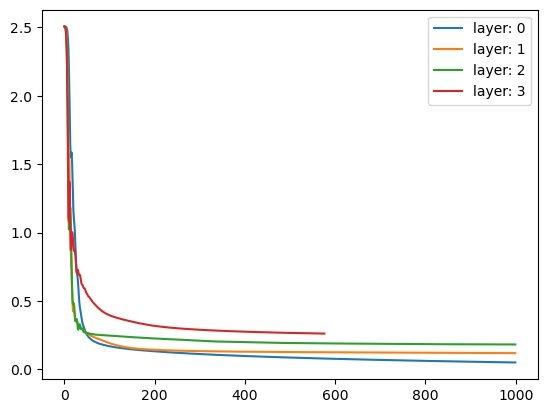

In [191]:
for i,ly in enumerate(ls):
  plt.plot(ls[i], label = 'layer: ' + str(i))
plt.legend(loc="upper right")

In [192]:
print('train acc:', net.predict(x_train).eq(y).float().mean().item())

train acc: 0.24990351498126984


## Prediction

In [193]:
x_test, Y_actual = next(iter(train_loader))

In [194]:
Y_preds = net.predict(x_test)

In [195]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.24990350877192982

Classification Report : 
              precision    recall  f1-score   support

       World       0.25      1.00      0.40     28489
      Sports       0.00      0.00      0.00     28536
    Business       0.00      0.00      0.00     28496
    Sci/Tech       0.00      0.00      0.00     28479

    accuracy                           0.25    114000
   macro avg       0.06      0.25      0.10    114000
weighted avg       0.06      0.25      0.10    114000


Confusion Matrix : 
[[28489     0     0     0]
 [28536     0     0     0]
 [28496     0     0     0]
 [28479     0     0     0]]


/Users/chenyihan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chenyihan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chenyihan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


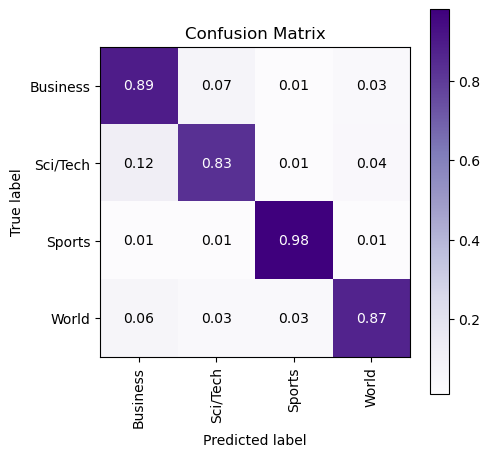

In [63]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

# Baseline - BP

## Dataset

In [13]:
def vectorize_batch(batch, embed_method = 'GloVe'):
    Y, X = list(zip(*batch))
    
    if embed_method == 'GloVe':
      X = [TOKENIZER(x) for x in X]
      X_tensor = torch.zeros(len(batch), 300)
      for i, tokens in enumerate(X):
          X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens).mean(dim=0) ## Averaging Embedding accross all words of text document
    
    if embed_method == 'sbert': #slow
      X_tensor = torch.cat([sbert_mapping[x].unsqueeze(0) for x in X], dim=0)

    return X_tensor, torch.tensor(Y) - 1 

In [14]:
num_train = round(0.95*len(train_dataset))
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_loader = DataLoader(split_train_, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))
valid_loader = DataLoader(split_valid_, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))
test_loader = DataLoader(test_dataset, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

In [15]:
for X, Y in train_loader:
    print(X)
    print(X.shape, Y.shape)
    break

tensor([[ 0.0502, -0.1701,  0.0519,  ..., -0.0307, -0.0274,  0.0059],
        [-0.0114,  0.0892, -0.0007,  ..., -0.1207, -0.0747,  0.0488],
        [ 0.0054,  0.0554,  0.0180,  ..., -0.0214,  0.0086,  0.0301],
        ...,
        [ 0.0123,  0.1037,  0.0116,  ..., -0.0751, -0.0273,  0.0164],
        [ 0.0184,  0.0347, -0.0088,  ...,  0.0337,  0.0019, -0.0339],
        [ 0.0598,  0.0329,  0.0438,  ...,  0.0194,  0.0605,  0.0896]])
torch.Size([1024, 384]) torch.Size([1024])


In [16]:
embed_len = X.shape[1]
embed_len

384

## Model

In [17]:
class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(embed_len, 256),
            nn.ReLU(),

            nn.Linear(256,128),
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, len(target_classes)),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

## Train the model

In [39]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        # print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        # print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))
        return(torch.tensor(losses).mean(), accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy()))

In [64]:
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            # X: Batch_size x (25*300)
            # Y: Batch_size x 1
            # Y_preds: Batch_size x num_class
            Y_preds = model(X) 

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(torch.tensor(losses).mean().item())
        train_acc.append(accuracy_score(Y.numpy(), Y_preds.argmax(dim=-1).numpy()))
        ls,ac = CalcValLossAndAccuracy(model, loss_fn, val_loader)
        val_loss.append(ls)
        val_acc.append(ac)

        if i%5==0:
            print("Train Loss : {:.4f}".format(train_loss[-1]))
            print("Train Acc  : {:.4f}".format(train_acc[-1]))
            print("Valid Loss : {:.4f}".format(ls))
            print("Valid Acc  : {:.4f}".format(ac))
            # CalcValLossAndAccuracy(model, loss_fn, val_loader)
    return(train_loss,train_acc,val_loss,val_acc)

In [65]:
epochs = 20
learning_rate = 5*1e-4

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

train_loss,train_acc,val_loss,val_acc = TrainModel(embed_classifier, loss_fn, optimizer, train_loader, valid_loader, epochs)

100%|██████████| 112/112 [00:01<00:00, 66.34it/s]


Train Loss : 0.2820
Train Acc  : 0.9226
Valid Loss : 0.2781
Valid Acc  : 0.9032


100%|██████████| 112/112 [00:01<00:00, 66.68it/s]


Train Loss : 0.2368
Train Acc  : 0.9494
Valid Loss : 0.2515
Valid Acc  : 0.9138


100%|██████████| 112/112 [00:01<00:00, 68.44it/s]


Train Loss : 0.1920
Train Acc  : 0.9643
Valid Loss : 0.2435
Valid Acc  : 0.9185


100%|██████████| 112/112 [00:01<00:00, 67.46it/s]


Train Loss : 0.1510
Train Acc  : 0.9851
Valid Loss : 0.2498
Valid Acc  : 0.9192


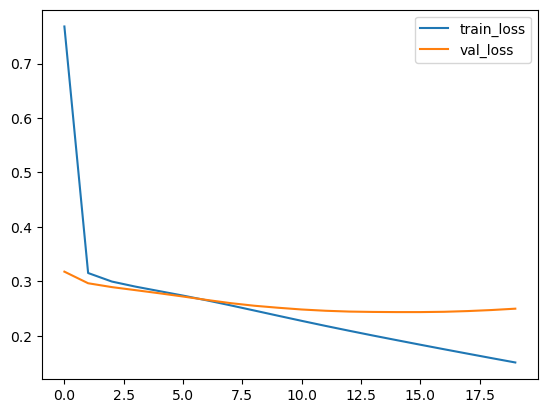

In [66]:
plt.plot(train_loss,label = 'train_loss')
plt.plot(val_loss,label = 'val_loss')
plt.legend(loc="upper right")

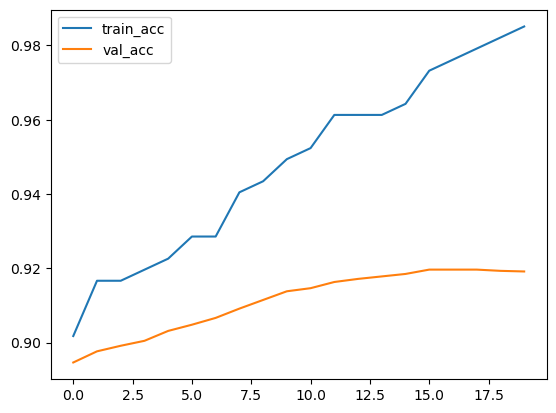

In [67]:
plt.plot(train_acc,label = 'train_acc')
plt.plot(val_acc,label = 'val_acc')
plt.legend(loc="upper left")

## Prediction

In [68]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

In [69]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9107894736842105

Classification Report : 
              precision    recall  f1-score   support

       World       0.92      0.90      0.91      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.89      0.86      0.87      1900
    Sci/Tech       0.87      0.90      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600


Confusion Matrix : 
[[1719   48   67   66]
 [  20 1862   13    5]
 [  73   13 1627  187]
 [  53   15  118 1714]]


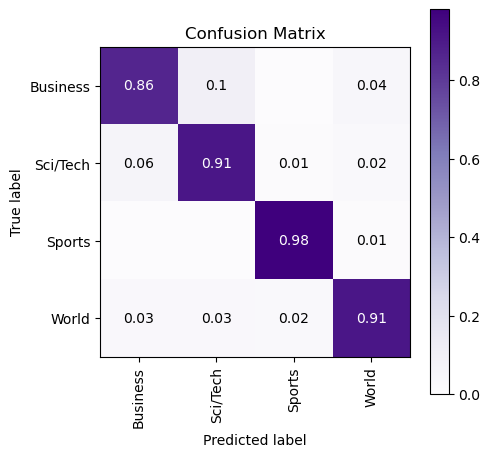

In [63]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);